In [2]:
!pip -q install pmdarima

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sbs 

from  datetime import datetime, timedelta
from tqdm.notebook import tqdm,trange

from pandas.plotting import lag_plot
from pandas import datetime
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


import os, warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_6304/1800022333.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [4]:
df_train = pd.read_csv('/kaggle/input/stock-investment-prediction/train.csv')
df_test = pd.read_csv('/kaggle/input/stock-investment-prediction/test.csv')
df_sub = pd.read_csv('/kaggle/input/stock-investment-prediction/sample_submission.csv')

In [5]:
df_train = pd.concat([df_train,df_sub.iloc[:6,:]])
df_train.reset_index(drop=True,inplace=True)
df_train

,id,price
0,1,0.455
1,2,0.465
2,3,0.450
3,4,0.445
4,5,0.440
...,...,...
3201,3202,60.000
3202,3203,62.500
3203,3204,61.000
3204,3205,63.000


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7725.311, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7722.751, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7722.875, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7725.082, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7724.091, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7723.474, Time=3.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7725.459, Time=3.91 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7722.662, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=7723.948, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7723.344, Time=1.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7722.788, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=7725.321, Time=1.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 11.871 seconds
                               SARIMAX Results                                
Dep. Var

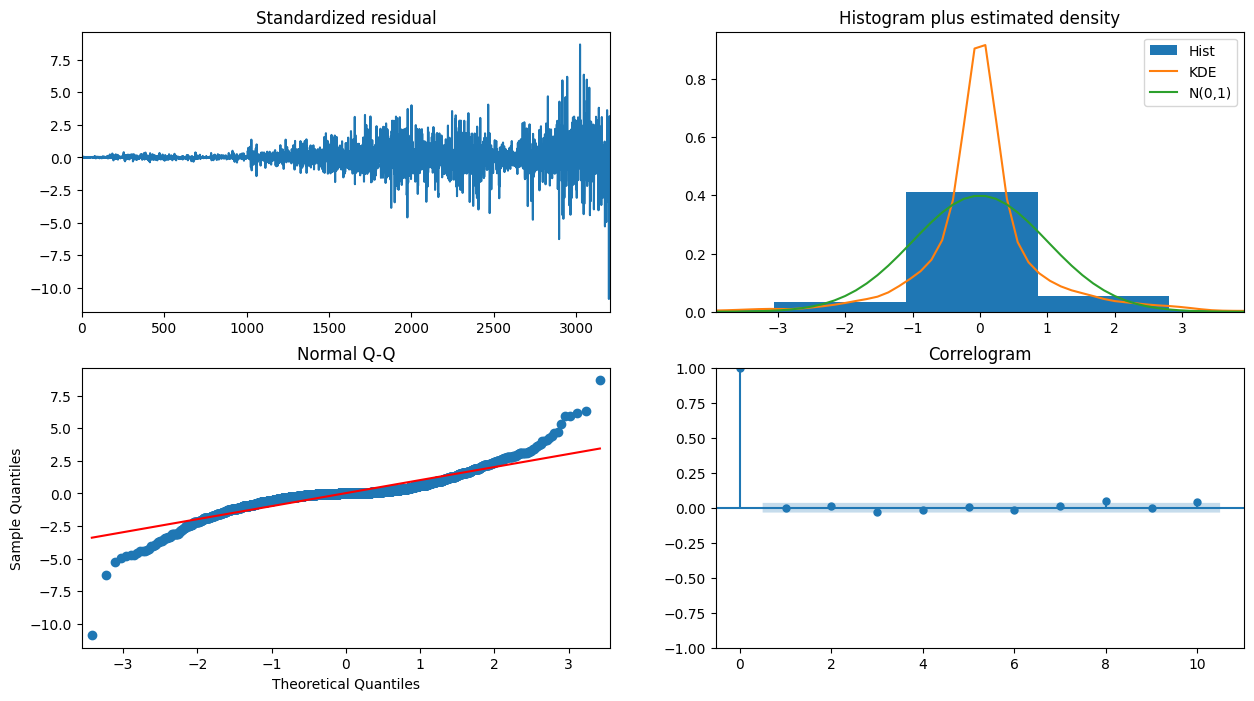

In [6]:
from pmdarima.arima import auto_arima
model_autoARIMA = auto_arima(df_train['price'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

count    3206.000000
mean       24.736742
std        22.196461
min         0.385000
25%         4.025000
50%        19.500000
75%        39.750000
max        93.250000
Name: price, dtype: float64

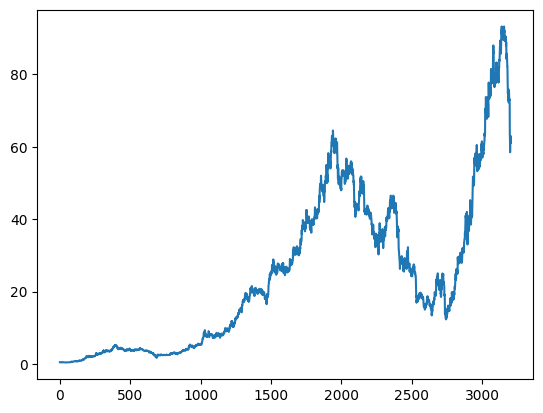

In [7]:
df_train['price'].plot()
df_train['price'].describe()

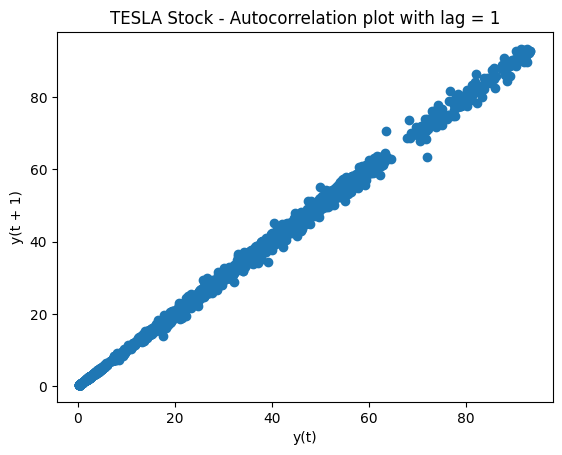

In [8]:
lag = 1

plt.figure()
lag_plot(df_train['price'], lag=lag)
plt.title(f'TESLA Stock - Autocorrelation plot with lag = {lag}')
plt.show()

In [9]:
def create_fea(df):
    lags = [1,2,3,4,5,10,14,28,56]
    lag_cols = [f"lag_{lag}" for lag in lags]
    for lag, lag_col in (zip(lags, lag_cols)):
        df[lag_col] = df["price"].shift(lag)
        
    wins = [5,10,15]
    for win in (wins) :
        for lag,lag_col in (zip(lags, lag_cols)):
            df[f"Rmean_{lag}_{win}"] = df["price"].transform(lambda x : x.rolling(win).mean())
    
    for win in (wins) :
        for lag,lag_col in (zip(lags, lag_cols)):
            df[f"Rstd_{lag}_{win}"] = df["price"].transform(lambda x : x.rolling(win).std())
            
    #Create Bollinger Bands
#     A = df['price'].rolling(window = 20).std()
#     df['upper_band'] = (df['price'].rolling(window = 20).mean()) + (A*2)
#     df['lower_band'] = (df['price'].rolling(window = 20).mean()) - (A*2)
    
    #Create Exponential moving average
#     df['ema'] = df['price'].ewm(com=0.5).mean()
    
            
    # Fit the ARIMA model
#     df['ARIMA_Residuals']  =0
    order = (1, 1, 0)  # Example ARIMA order (p, d, q)
    model = sm.tsa.arima.ARIMA(df['lag_1'], order=order)
    model_fit = model.fit()
     
    # Extract the residuals
    residuals = model_fit.resid
    df['ARIMA_Residuals'] = residuals

        

In [10]:
create_fea(df_train)
df_train

,id,price,lag_1,lag_2,lag_3,lag_4,lag_5,lag_10,lag_14,lag_28,...,Rstd_1_15,Rstd_2_15,Rstd_3_15,Rstd_4_15,Rstd_5_15,Rstd_10_15,Rstd_14_15,Rstd_28_15,Rstd_56_15,ARIMA_Residuals
0,1,0.455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.465,0.455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.455000
2,3,0.450,0.465,0.455,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010000
3,4,0.445,0.450,0.465,0.455,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014645
4,5,0.440,0.445,0.450,0.465,0.455,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3201,3202,60.000,58.500,62.250,63.250,72.000,72.25,73.25,76.00,88.50,...,6.003868,6.003868,6.003868,6.003868,6.003868,6.003868,6.003868,6.003868,6.003868,-3.785534
3202,3203,62.500,60.000,58.500,62.250,63.250,72.00,75.50,74.00,84.25,...,6.099473,6.099473,6.099473,6.099473,6.099473,6.099473,6.099473,6.099473,6.099473,1.366749
3203,3204,61.000,62.500,60.000,58.500,62.250,63.25,74.25,75.00,85.25,...,6.318812,6.318812,6.318812,6.318812,6.318812,6.318812,6.318812,6.318812,6.318812,2.553300
3204,3205,63.000,61.000,62.500,60.000,58.500,62.25,72.75,72.25,85.25,...,6.200134,6.200134,6.200134,6.200134,6.200134,6.200134,6.200134,6.200134,6.200134,-1.411166


In [11]:
df_train.dropna(inplace = True)
df_train.shape
df_train.reset_index(drop=True,inplace=True)

In [12]:
df_train

,id,price,lag_1,lag_2,lag_3,lag_4,lag_5,lag_10,lag_14,lag_28,...,Rstd_1_15,Rstd_2_15,Rstd_3_15,Rstd_4_15,Rstd_5_15,Rstd_10_15,Rstd_14_15,Rstd_28_15,Rstd_56_15,ARIMA_Residuals
0,57,0.435,0.435,0.420,0.405,0.405,0.400,0.395,0.385,0.420,...,0.014450,0.014450,0.014450,0.014450,0.014450,0.014450,0.014450,0.014450,0.014450,0.015533
1,58,0.420,0.435,0.435,0.420,0.405,0.405,0.405,0.395,0.430,...,0.013558,0.013558,0.013558,0.013558,0.013558,0.013558,0.013558,0.013558,0.013558,0.000533
2,59,0.420,0.420,0.435,0.435,0.420,0.405,0.410,0.390,0.415,...,0.013292,0.013292,0.013292,0.013292,0.013292,0.013292,0.013292,0.013292,0.013292,-0.015000
3,60,0.420,0.420,0.420,0.435,0.435,0.420,0.410,0.400,0.410,...,0.012228,0.012228,0.012228,0.012228,0.012228,0.012228,0.012228,0.012228,0.012228,-0.000533
4,61,0.420,0.420,0.420,0.420,0.435,0.435,0.405,0.395,0.410,...,0.011872,0.011872,0.011872,0.011872,0.011872,0.011872,0.011872,0.011872,0.011872,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,3202,60.000,58.500,62.250,63.250,72.000,72.250,73.250,76.000,88.500,...,6.003868,6.003868,6.003868,6.003868,6.003868,6.003868,6.003868,6.003868,6.003868,-3.785534
3146,3203,62.500,60.000,58.500,62.250,63.250,72.000,75.500,74.000,84.250,...,6.099473,6.099473,6.099473,6.099473,6.099473,6.099473,6.099473,6.099473,6.099473,1.366749
3147,3204,61.000,62.500,60.000,58.500,62.250,63.250,74.250,75.000,85.250,...,6.318812,6.318812,6.318812,6.318812,6.318812,6.318812,6.318812,6.318812,6.318812,2.553300
3148,3205,63.000,61.000,62.500,60.000,58.500,62.250,72.750,72.250,85.250,...,6.200134,6.200134,6.200134,6.200134,6.200134,6.200134,6.200134,6.200134,6.200134,-1.411166


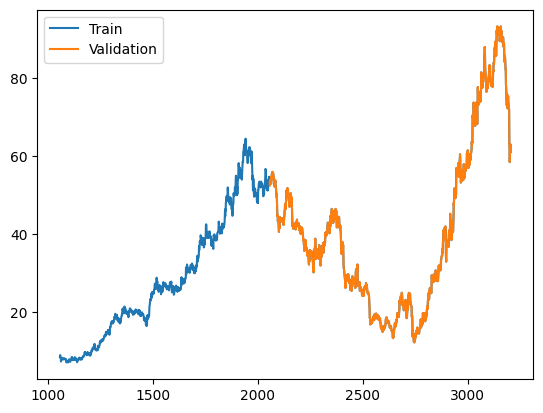

In [28]:
ratio = 1
split = int(len(df_train) * ratio)
b = 2000
start = 1000
dates_train,X_train, y_train =  df_train.iloc[start:split,0], df_train.iloc[start:split,2:], df_train.iloc[start:split,1]
dates_test,X_test, y_test =  df_train.iloc[b:,0], df_train.iloc[b:,2:], df_train.iloc[b:,1]
plt.plot(dates_train, y_train)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation'])

In [29]:
dates_train.shape, X_train.shape, y_train.shape

((2150,), (2150, 64), (2150,))

In [30]:
# N = X_train.shape[1]
N = 100

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping,ModelCheckpoint


import tensorflow as tf

model = Sequential([
                    # Add the Input layer
                    layers.Input((X_train.shape[1], 1)),
                    # Add the first LSTM layer
                    layers.LSTM(N,return_sequences=True),
                    layers.Dropout(0.2),
                    layers.BatchNormalization(),
                    
                    # Add a second LSTM layer
                    layers.LSTM(N,return_sequences=True),
                    layers.Dropout(0.2),
                    layers.BatchNormalization(),
                    
                    # Add a third LSTM layer
                    layers.LSTM(N,return_sequences=True),
                    layers.Dropout(0.2),
                    layers.BatchNormalization(),
    
                     # Add a forth LSTM layer
                    layers.LSTM(N,return_sequences=False),
                    layers.Dropout(0.2),
                    layers.BatchNormalization(),
    
                    # Add a dense layer
                    layers.Dense(64, activation='relu'),
                    layers.Dropout(0.2),

#                     layers.Dense(32, activation='relu'),
#                     layers.Dropout(0.2),    
                   
                    # Add the output layer
                    layers.Dense(1)])


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 64, 100)           40800     
                                                                 
 dropout_10 (Dropout)        (None, 64, 100)           0         
                                                                 
 batch_normalization_8 (Batc  (None, 64, 100)          400       
 hNormalization)                                                 
                                                                 
 lstm_9 (LSTM)               (None, 64, 100)           80400     
                                                                 
 dropout_11 (Dropout)        (None, 64, 100)           0         
                                                                 
 batch_normalization_9 (Batc  (None, 64, 100)          400       
 hNormalization)                                      

In [32]:

# Custom learning rate scheduler
def lr_schedule(epoch, lr):
    if epoch < 50:
        return lr 
    else:
        return lr * tf.math.exp(-0.1)


# Compile the model
initial_learning_rate = 1e-4
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='mse',metrics=['mean_absolute_error'])

# Define the learning rate scheduler callback
lr_schedule = LearningRateScheduler(lr_schedule)


early_stopping = EarlyStopping(monitor='val_loss',mode='min',patience=40)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)


In [33]:
# Train the model with the learning rate scheduler callback
history = model.fit(X_train, y_train, epochs=200, callbacks=[mc, lr_schedule,early_stopping],validation_data=(X_test, y_test))  #,validation_data=(X_test, y_test)

Epoch 1/200
68/68 [==============================] - 13s 61ms/step - loss: 1505.4669 - mean_absolute_error: 34.5055 - val_loss: 2063.7849 - val_mean_absolute_error: 40.3892 - lr: 1.0000e-04
Epoch 2/200
68/68 [==============================] - 2s 30ms/step - loss: 1266.8597 - mean_absolute_error: 31.9078 - val_loss: 1896.3458 - val_mean_absolute_error: 39.0343 - lr: 1.0000e-04
Epoch 3/200
68/68 [==============================] - 2s 31ms/step - loss: 1078.9572 - mean_absolute_error: 29.5013 - val_loss: 1580.4778 - val_mean_absolute_error: 35.9250 - lr: 1.0000e-04
Epoch 4/200
68/68 [==============================] - 2s 29ms/step - loss: 899.3595 - mean_absolute_error: 26.8905 - val_loss: 1235.6890 - val_mean_absolute_error: 31.9253 - lr: 1.0000e-04
Epoch 5/200
68/68 [==============================] - 2s 29ms/step - loss: 732.7394 - mean_absolute_error: 24.2065 - val_loss: 875.9891 - val_mean_absolute_error: 26.7859 - lr: 1.0000e-04
Epoch 6/200
68/68 [==============================] - 2s 2

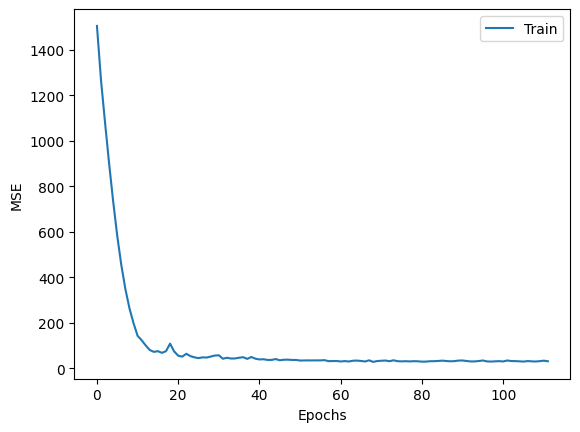

In [34]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Test']);

In [35]:
model.load_weights('/kaggle/working/best_model.h5')

68/68 [==============================] - 2s 8ms/step


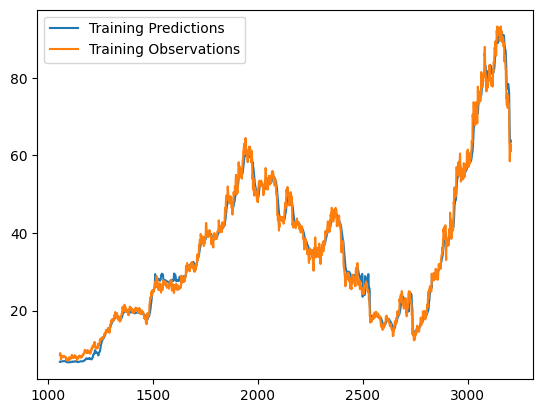

In [36]:
train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

7/7 [==============================] - 0s 8ms/step


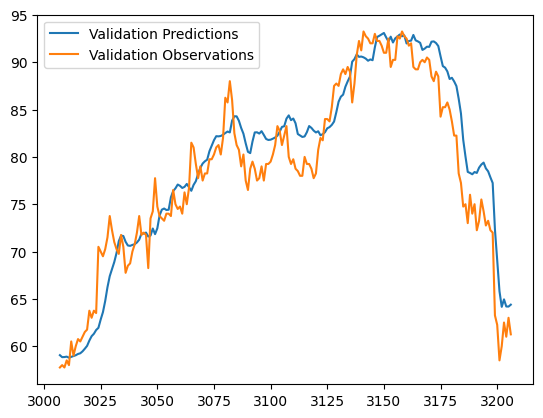

In [107]:
b = 200
dates_test,X_test, y_test =  df_train.iloc[-b:,0], df_train.iloc[-b:,2:], df_train.iloc[-b:,1]

test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions*1.0125)
plt.plot(dates_test, y_test)
plt.legend(['Validation Predictions', 'Validation Observations'])

7/7 [==============================] - 0s 7ms/step


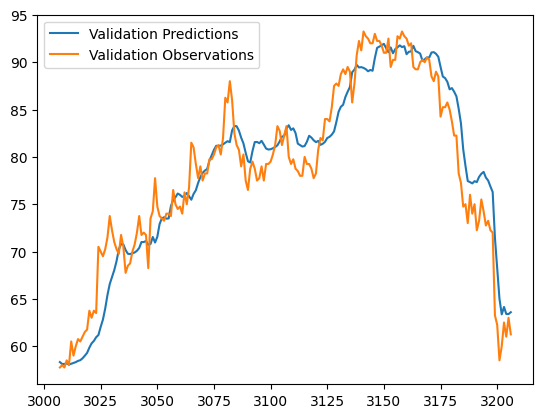

In [38]:
b = 200
dates_test,X_test, y_test =  df_train.iloc[-b:,0], df_train.iloc[-b:,2:], df_train.iloc[-b:,1]

test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [108]:
df_all = pd.read_csv('/kaggle/input/stock-investment-prediction/train.csv')
df_all = pd.concat([df_all,df_sub.iloc[:6,:]])
df_all.reset_index(drop=True,inplace=True)
df_all

,id,price
0,1,0.455
1,2,0.465
2,3,0.450
3,4,0.445
4,5,0.440
...,...,...
3201,3202,60.000
3202,3203,62.500
3203,3204,61.000
3204,3205,63.000


In [109]:
for day in trange(295):
    df_all = pd.concat([df_all,df_all.iloc[:1,:]], ignore_index=True)
    df_all['id'][len(df_all)-1]= df_all['id'][len(df_all)-2]+1
    create_fea(df_all)
    
    result = model.predict(df_all.iloc[-2:-1,2:]).item()
    df_all['price'][len(df_all)-1] = result*1.0125
    

  0%|          | 0/295 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


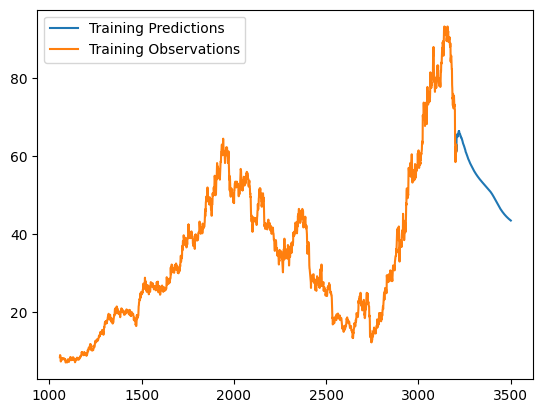

In [110]:
#1.0125
plt.plot(df_all.iloc[3201:,0], df_all.iloc[3201:,1])
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

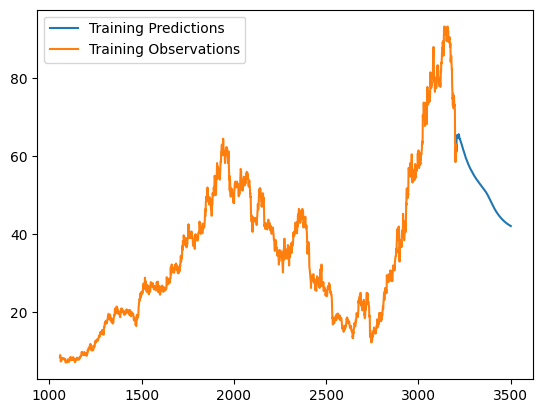

In [100]:
#1.010
plt.plot(df_all.iloc[3201:,0], df_all.iloc[3201:,1])
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

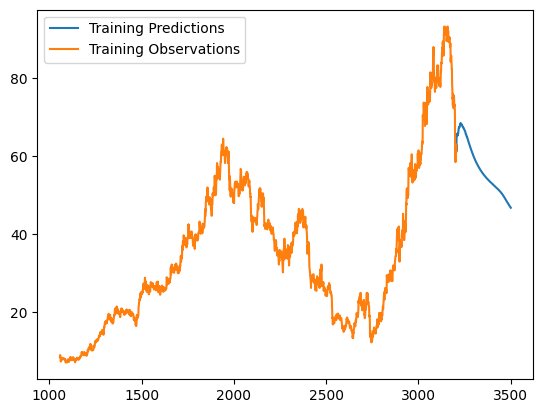

In [103]:
#1.015
plt.plot(df_all.iloc[3201:,0], df_all.iloc[3201:,1])
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

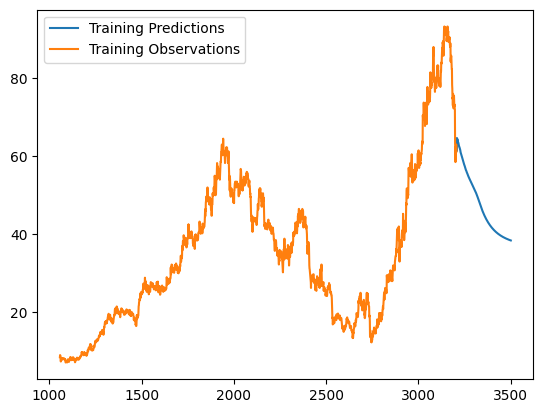

In [72]:
plt.plot(df_all.iloc[3201:,0], df_all.iloc[3201:,1])
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

In [111]:
df_submit = df_sub.copy()
df_submit

,id,price
0,3201,58.5
1,3202,60.0
2,3203,62.5
3,3204,61.0
4,3205,63.0
...,...,...
295,3496,NaN
296,3497,NaN
297,3498,NaN
298,3499,NaN


In [112]:
df_submit['price'][6:] = df_all.iloc[3206:-1,1]
df_submit

,id,price
0,3201,58.500000
1,3202,60.000000
2,3203,62.500000
3,3204,61.000000
4,3205,63.000000
...,...,...
295,3496,43.710345
296,3497,43.672023
297,3498,43.634195
298,3499,43.596857


In [113]:
df_submit.to_csv('submission_plus_10125.csv',index=False)

# Method test2

In [127]:
df_all = pd.read_csv('/kaggle/input/stock-investment-prediction/train.csv')
df_all = pd.concat([df_all,df_sub.iloc[:6,:]])
df_all.reset_index(drop=True,inplace=True)
df_all

,id,price
0,1,0.455
1,2,0.465
2,3,0.450
3,4,0.445
4,5,0.440
...,...,...
3201,3202,60.000
3202,3203,62.500
3203,3204,61.000
3204,3205,63.000


In [2]:
for day in trange(295):
    df_all = pd.concat([df_all,df_all.iloc[:1,:]], ignore_index=True)
    df_all['id'][len(df_all)-1]= df_all['id'][len(df_all)-2]+1
    create_fea(df_all)
    
    result = model.predict(df_all.iloc[-2:-1,2:]).item()
    df_all['price'][len(df_all)-1] = result*0.965

NameError: name 'trange' is not defined